# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1tGcX2qzS2GoaN5zFeD5DVJxqDmoQdmMs7QncZwFCEqU/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's totally optional whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_All code should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach._

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [2]:
# all import statements needed for the project, for example:

import math
import numpy as np
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import datetime
import os
import csv
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins

%matplotlib inline

In [2]:
# any general notebook setup, like log formatting

In [13]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library
* [ ] Write at least one unit test that tests this distance calculation function. 
* Taxi data:
    * [ ] Use `requests`, BeautifulSoup (`bs4`), and `pandas` to programmatically download the required CSV files & load into memory.
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box]
* Using the function that calculates the distance between two coordinates in kilometers, add a column to each `pandas` DataFrame of data that calculates the distance between pickup and dropoff locations for each trip.
* Weather data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
        * You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 
* Take a look at the lecture notes from the `pandas` lecture for hints on helpful functionality

### Calculating distance
_Write some prose that tells the reader what you're about to do here._

In [3]:
def cal_straight_distance(data: list) -> list:
    ## the difference of longitude
    x_start = data['pickup_longitude'] * 111
    x_end = data['dropoff_longitude'] * 111
    ## the difference of latitude
    y_start = data['pickup_latitude'] * 111
    y_end = data['dropoff_latitude'] * 111
    ## the straight distance
    data['Trip_distance'] = pow((pow(x_end-x_start, 2) + pow(y_end-y_start, 2)), 0.5)

In [4]:
def test_calculate_distance() -> bool:
    x = cal_straight_distance(data)[0]
    assert x/1.6 <= data['Trip_Distance'][0]

### Processing Uber Data

_Write some prose that tells the reader what you're about to do here._

In [5]:
def load_and_clean_uber_data(csv_file='/Users/z.z/Desktop/Course material/22SP/4501/Final project/uber_rides_sample.csv') -> list:
    path = csv_file
    df = pd.read_csv(path)
    df = df.loc[(df['pickup_longitude'] <=  -73.717047) & (df['pickup_longitude'] >=  -74.242330)\
                & (df['dropoff_longitude'] <=  -73.717047) & (df['dropoff_longitude'] >=  -74.242330)
                & (df['pickup_latitude'] <=  40.908524) & (df['pickup_latitude'] >=  40.560445) \
                & (df['dropoff_latitude'] <=  40.908524) & (df['dropoff_latitude'] >=  40.560445)]
    df = df.sort_values(by='key',ascending=True).reset_index()
    df.drop(['index', 'Unnamed: 0', 'pickup_datetime'],axis=1, inplace=True)
    df.rename(columns={'key':'raw_date'}, inplace = True)
    split = df['raw_date'].str.split(' ', expand=True)
    df['date'] = split[0]
    df['hour'] = split[1].str.split(':',expand = True)[0]
#     df.drop('raw_date', axis=1, inplace=True)
    df = df.iloc[:,[6,7,0,1,2,3,4,5]]
    df['date'] = pd.to_datetime(df['date'])
    df['dates'] = df['date'].dt.strftime('%Y-%m')
    number_of_data = (df.groupby('dates').count()['date'])
    df['week_name'] = df['date'].dt.day_name()
    
#     df['date'] = pd.Timestamp(df['date'])
    return df, number_of_data
    

### Processing Taxi Data

_Write some prose that tells the reader what you're about to do here._

In [6]:
def find_taxi_csv_urls() -> list:
    # create a list to store the url from 2009-2015
    url_list = []
    for y in range(9, 16):
        if y == 9:
            for i in range(1, 13):
                if i <= 9:
                    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-0{i}.csv"
                    url_list.append(url)
                else:
                    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-{i}.csv"
                    url_list.append(url)
        elif y <= 14 and y > 9:
            for i in range(1, 13):
                if i <= 9:
                    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_20{y}-0{i}.csv"
                    url_list.append(url)
                else:
                    url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_20{y}-{i}.csv"
                    url_list.append(url)
        else:
            for i in range(1, 7):
                url = f"https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_20{y}-0{i}.csv"
                url_list.append(url)
    return url_list

def get_and_clean_month_taxi_data(url: str, i: int) -> None:
    response = requests.get(url)
    with open('out.csv', 'w') as f:
        writer = csv.writer(f)
        for line in response.iter_lines():
            writer.writerow(line.decode('utf-8').split(','))
    data = pd.read_csv('out.csv',low_memory = False)
    data = data.drop(['RateCodeID', 'store_and_fwd_flag', 'payment_type', 'improvement_surcharge', 'mta_tax', 'tolls_amount', 'total_amount'], axis=1)
    data.dropna(inplace=True)
    data = data.loc[(data['pickup_longitude'] <=  -73.717047) & (data['pickup_longitude'] >=  -74.242330)\
                    & (data['dropoff_longitude'] <=  -73.717047) & (data['dropoff_longitude'] >=  -74.242330)
                    & (data['pickup_latitude'] <=  40.908524) & (data['pickup_latitude'] >=  40.560445) \
                    & (data['dropoff_latitude'] <=  40.908524) & (data['dropoff_latitude'] >=  40.560445)]
    sample = data.sample(b[i])
    sample = sample.sort_values(by='tpep_pickup_datetime',ascending=True).reset_index()
    sample = sample.drop(['index'], axis=1)
    data_csv = sample.to_csv(path_or_buf=f'/Users/z.z/Desktop/Course material/22SP/4501/Final project/month_{i}.csv')

def download_data(url_list: list) -> list:
    for i in range(73,78):
        url=url_list[i]
        get_and_clean_month_taxi_data(url,i)
    
    
def get_and_clean_taxi_data() -> list:
    csv_list = []
    for i in range(0,78):
        df = pd.read_csv(f'/Users/z.z/Desktop/Course material/22SP/4501/Final project/Final_project/taxi/month_{i}.csv')
        csv_list.append(df)
    taxi = pd.concat(csv_list,axis = 0)
    taxi.drop(['raw_ind', 'vendor_id'], axis=1, inplace=True)
    taxi.index = range(len(taxi))
    taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
    taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])
    return taxi

In [65]:
# ### This is the process for getting the taxi data files
# uber_data, b = load_and_clean_uber_data(csv_file='/Users/z.z/Desktop/Course material/22SP/4501/Final project/uber_rides_sample.csv')
# url_list = find_taxi_csv_urls()
# download_data(url_list)

### Processing Weather Data

_Write some prose that tells the reader what you're about to do here._

In [7]:
def clean_month_weather_data_hourly() -> list:
    csv_list = []
    for i in range(1,8):
        df = pd.read_csv(f'/Users/z.z/Desktop/Course material/22SP/4501/Final project/Final_project/weather/{i}_weather.csv')
        csv_list.append(df)
    weather = pd.concat(csv_list,axis = 0)
    clean = weather[['DATE','LATITUDE','LONGITUDE','HourlyPrecipitation','HourlyPresentWeatherType','HourlyRelativeHumidity','HourlyVisibility','HourlyWindDirection','HourlyWindGustSpeed','HourlyWindSpeed','Sunrise','Sunset','HourlyDryBulbTemperature']]
    clean.fillna('0', inplace=True)
    clean.index = range(len(clean))
    clean['DATE'] = pd.to_datetime(clean['DATE'])
    clean['HourlyPrecipitation'] = clean['HourlyPrecipitation'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    clean['HourlyRelativeHumidity'] = clean['HourlyRelativeHumidity'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    clean['HourlyVisibility'] = clean['HourlyVisibility'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    clean['HourlyWindGustSpeed'] = clean['HourlyWindGustSpeed'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    clean['HourlyWindSpeed'] = clean['HourlyWindSpeed'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    clean['HourlyDryBulbTemperature'] = clean['HourlyDryBulbTemperature'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    return clean
    
    
def clean_month_weather_data_daily() -> list:
    weather_hourly = clean_month_weather_data_hourly()
    weather_daily = pd.DataFrame()
    weather_daily['DATE'] = weather_hourly['DATE'].dt.strftime('%Y-%m-%d')
    weather_daily['DailyVisibility'] = weather_hourly['HourlyVisibility'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily['DailyPrecipitation'] = weather_hourly['HourlyPrecipitation'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily['DailyRelativeHumidity'] = weather_hourly['HourlyRelativeHumidity'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily['DailyWindGustSpeed'] = weather_hourly['HourlyWindGustSpeed'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily['DailyWindSpeed'] = weather_hourly['HourlyWindSpeed'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily['DailyDryBulbTemperature'] = weather_hourly['HourlyDryBulbTemperature'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
    weather_daily = weather_daily.groupby(by='DATE').mean()
    weather_daily[['LATITUDE','LONGITUDE']] = ['40.77898','-73.96925']
    
    return weather_daily


### Process All Data

_In this part, we are going to use the function we define above to gain the dataframes._

_The cvs files we used below are from our local computer._

In [18]:
## Using the method above to add "Trip_distance" column
uber_data, b = load_and_clean_uber_data(csv_file='/Users/z.z/Desktop/Course material/22SP/4501/Final project/uber_rides_sample.csv')
cal_straight_distance(uber_data)
taxi_data = get_and_clean_taxi_data()
weather_hourly = clean_month_weather_data_hourly()
weather_daily = clean_month_weather_data_daily()

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [10]:
import logging
engine = db.create_engine(f'sqlite:///contacts.db',echo = False)

In [11]:
from sqlalchemy.orm import declarative_base
Base = declarative_base()

In [13]:
from sqlalchemy import Column, Integer, String, Date, Float
from sqlalchemy.orm import validates

In [14]:
Base.metadata.create_all(engine, checkfirst=True)

[sqlalchemy] BEGIN (implicit)
[sqlalchemy] COMMIT


In [12]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE weather_hourly (
    "index" BIGINT, 
    "DATE" DATETIME, 
    "LATITUDE" FLOAT, 
    "LONGITUDE" FLOAT, 
    "HourlyPrecipitation" FLOAT, 
    "HourlyPresentWeatherType" TEXT, 
    "HourlyRelativeHumidity" FLOAT, 
    "HourlyVisibility" FLOAT, 
    "HourlyWindDirection" TEXT, 
    "HourlyWindGustSpeed" FLOAT, 
    "HourlyWindSpeed" FLOAT, 
    "Sunrise" TEXT, 
    "Sunset" TEXT, 
    "HourlyDryBulbTemperature" FLOAT
)

"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE weather_daily (
    "DATE" TEXT, 
    "DailyVisibility" FLOAT, 
    "DailyPrecipitation" FLOAT, 
    "DailyRelativeHumidity" FLOAT, 
    "DailyWindGustSpeed" FLOAT, 
    "DailyWindSpeed" FLOAT, 
    "DailyDryBulbTemperature" FLOAT, 
    "LATITUDE" TEXT, 
    "LONGITUDE" TEXT
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE taxi_data (
    "index" BIGINT, 
    pickup_datetime DATETIME, 
    dropoff_datetime DATETIME, 
    passenger_count BIGINT, 
    trip_distance FLOAT, 
    pickup_longitude FLOAT, 
    pickup_latitude FLOAT, 
    dropoff_longitude FLOAT, 
    dropoff_latitude FLOAT, 
    fare_amount FLOAT, 
    tip_amount FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE uber_data (
    "index" BIGINT, 
    passenger_count BIGINT, 
    date DATETIME, 
    raw_date TEXT, 
    fare_amount FLOAT, 
    pickup_longitude FLOAT, 
    pickup_latitude FLOAT, 
    dropoff_longitude FLOAT, 
    dropoff_latitude FLOAT, 
    dates TEXT, 
    week_name TEXT, 
    "Trip_distance" FLOAT
)
"""

In [78]:
# create that required schema.sql file
with open('schema.sql', "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [14]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_Write some prose that tells the reader what you're about to do here._

In [19]:
uber_data.to_sql('uber_data', con=engine)
taxi_data.to_sql('taxi_data', con=engine)
weather_hourly.to_sql('weather_hourly', con=engine)
weather_daily.to_sql('weather_daily', con=engine)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

### Query N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [20]:
QUERY_1 = """
SELECT COUNT("index"),strftime ('%H',pickup_datetime) hour
FROM taxi_data
GROUP BY strftime ('%H',pickup_datetime)
"""


QUERY_2 = """
SELECT COUNT("index"),week_name
FROM uber_data
GROUP BY week_name
ORDER BY COUNT("index")
"""

QUERY_3 = """
SELECT "Trip_distance"
FROM 
(SELECT "Trip_distance"
FROM uber_data
WHERE strftime ('%Y-%m',date) == '2013-07'
UNION ALL
SELECT trip_distance
FROM taxi_data 
WHERE strftime ('%Y-%m',pickup_datetime) == '2013-07')
ORDER BY "Trip_distance" ASC
LIMIT 1
OFFSET (SELECT
         COUNT(*)
        FROM 
(SELECT "Trip_distance"
FROM uber_data
WHERE strftime ('%Y-%m',date) == '2013-07'
UNION ALL
SELECT trip_distance
FROM taxi_data 
WHERE strftime ('%Y-%m',pickup_datetime) == '2013-07')    
    ) * 18 / 20 - 1

"""

QUERY_4 = """
SELECT a.time, avg(a."Trip_distance"), count(a.time)
FROM
(SELECT strftime ('%Y-%m-%d', date) as time, "Trip_distance"
FROM uber_data
WHERE strftime ('%Y',date) == '2009'
UNION ALL
SELECT strftime ('%Y-%m-%d', pickup_datetime) as time, trip_distance
FROM taxi_data 
WHERE strftime ('%Y',pickup_datetime) == '2009') as a
GROUP BY time
ORDER BY count(time) DESC
LIMIT 10
"""


QUERY_5 = """
SELECT b.b_time, b.rides, weather_daily."DailyWindSpeed"

FROM
(SELECT a.time as b_time, count(a.time) as rides
FROM
(SELECT strftime ('%Y-%m-%d', date) as time, "Trip_distance"
FROM uber_data
WHERE strftime ('%Y',date) == '2014'
UNION ALL
SELECT strftime ('%Y-%m-%d', pickup_datetime) as time, trip_distance
FROM taxi_data 
WHERE strftime ('%Y',pickup_datetime) == '2014') as a
GROUP BY time) as b 
JOIN weather_daily
ON b.b_time = weather_daily."DATE"
ORDER BY weather_daily."DailyWindSpeed" DESC
LIMIT 10
"""

QUERY_6 = """
SELECT hour3, count3, pre, wind
FROM
(SELECT hour2 as hour3, sum(count2) as count3
FROM
(WITH RECURSIVE dates(x,y) AS ( 
            SELECT '2012-10-22 00:00' , 0
                UNION ALL 
            SELECT DATETIME(x, '+1 HOURS') ,0 FROM dates WHERE x<'2012-11-07 00:00' 
) 
SELECT strftime ('%Y-%m-%d-%H',x) as hour2, y as count2 FROM dates 
UNION
SELECT hour1, count1
FROM
(SELECT a.date as hour1, COUNT(a.distance) as count1
FROM
(SELECT strftime ('%Y-%m-%d-%H',raw_date) as date, "Trip_distance" as distance
FROM uber_data
WHERE raw_date between '2012-10-22 00:00' and '2012-11-07 00:00'
UNION ALL
SELECT strftime ('%Y-%m-%d-%H',pickup_datetime),trip_distance
FROM taxi_data 
WHERE pickup_datetime between '2012-10-22 00:00' and '2012-11-07 00:00') as a
GROUP BY date))
GROUP BY hour2)
LEFT JOIN
(SELECT strftime ('%Y-%m-%d-%H', DATE) as hour, avg("HourlyPrecipitation") as pre, avg("HourlyWindSpeed") as wind
FROM weather_hourly
WHERE hour between '2012-10-22' and '2012-11-07'
GROUP BY hour)
ON hour3 = hour
"""

In [21]:
# Query 1
query1 = engine.execute(QUERY_1).fetchall()
for i in query1:
    print(i)
print('=========================')
print(f'The most popular hour of the day to take yellow taxi is:{max(query1)[1]}:00 PM')

(7780, '00')
(5826, '01')
(4408, '02')
(3116, '03')
(2262, '04')
(1870, '05')
(4047, '06')
(7110, '07')
(8834, '08')
(9013, '09')
(8774, '10')
(9095, '11')
(9574, '12')
(9535, '13')
(9859, '14')
(9228, '15')
(8076, '16')
(9673, '17')
(11808, '18')
(12363, '19')
(11286, '20')
(11298, '21')
(10889, '22')
(9748, '23')
The most popular hour of the day to take yellow taxi is:19:00 PM


In [22]:
# Query 2
query2 = engine.execute(QUERY_2).fetchall()
for i in query2:
    print(i)
print('=========================')
print(f'{max(query2)[1]} is the most popular day of the week to take uber')

(24681, 'Monday')
(25834, 'Sunday')
(27526, 'Tuesday')
(28328, 'Wednesday')
(29338, 'Thursday')
(29599, 'Saturday')
(30166, 'Friday')
Friday is the most popular day of the week to take uber


In [24]:
# Query 3
query3 = engine.execute(QUERY_3).fetchall()
print('=========================')
print(f'95% percentile of distance traveled of all hired trips during July 2013 is {query3[0][0]} kilometers')

95% percentile of distance traveled of all hired trips during July 2013 is 7.266198581652441 kilometers


In [25]:
# Query 4
query4 = engine.execute(QUERY_4).fetchall()
print('=========================')
print(f'Top 10 days with highest number of rides in 2009, and all the required data shown belowed:')
print('Date'+'|'+'AVG Distance'+'|'+'Number of rides')
for i in query4:
    print(i)

Top 10 days with highest number of rides in 2009, and all the required data shown belowed:
Date|AVG Distance|Number of rides
('2009-12-11', 3.0033017817241747, 239)
('2009-03-19', 3.244786877323046, 222)
('2009-04-18', 3.415300991771839, 221)
('2009-12-05', 2.8456978626774583, 219)
('2009-10-23', 2.6995602894934274, 214)
('2009-04-04', 2.977452695934878, 210)
('2009-03-20', 3.1420790786458843, 209)
('2009-12-10', 3.0669361501935986, 208)
('2009-05-16', 3.0093628874092215, 207)
('2009-05-08', 3.2056544585572992, 207)


In [26]:
# Query 5
query5 = engine.execute(QUERY_5).fetchall()
print('=========================')
print(f'Top 10 windest days in 2014, and all the required data shown belowed:')
print('Date'+'       '+'Number of rides'+'     '+'Daily AVG Windspeed')
for i in query5:
    print(i)

Top 10 windest days in 2014, and all the required data shown belowed:
Date       Number of rides     Daily AVG Windspeed
('2014-03-13', 201, 12.923076923076923)
('2014-01-07', 160, 12.56)
('2014-01-02', 113, 12.352941176470589)
('2014-02-13', 120, 11.781818181818181)
('2014-03-29', 212, 11.666666666666666)
('2014-12-07', 154, 11.153846153846153)
('2014-12-09', 153, 11.056603773584905)
('2014-12-08', 164, 10.903225806451612)
('2014-03-26', 186, 10.52)
('2014-01-03', 82, 9.710526315789474)


In [27]:
# Query 6
query6 = engine.execute(QUERY_6).fetchall()
print('=========================')
print(f'During 2012-10-22 00:00 to 2012-11-07 00:00, hourly data for number of trips,precipitation,windspeed showed below')
print('Date'+'|'+'Number of rides'+'|'+'precipitation' +'|'+'windspeed')  
for i in query6:
    print(i)

During 2012-10-22 00:00 to 2012-11-07 00:00, hourly data for number of trips,precipitation,windspeed showed below
Date|Number of rides|precipitation|windspeed
('2012-10-22-00', 2, 0.0, 7.0)
('2012-10-22-01', 2, 0.0, 5.0)
('2012-10-22-02', 2, 0.0, 7.0)
('2012-10-22-03', 1, 0.0, 0.0)
('2012-10-22-04', 0, 0.0, 0.0)
('2012-10-22-05', 2, 0.0, 0.0)
('2012-10-22-06', 4, 0.0, 5.0)
('2012-10-22-07', 7, 0.0, 3.0)
('2012-10-22-08', 6, 0.0, 3.0)
('2012-10-22-09', 8, 0.0, 5.0)
('2012-10-22-10', 6, 0.0, 0.0)
('2012-10-22-11', 9, 0.0, 0.0)
('2012-10-22-12', 11, 0.0, 11.0)
('2012-10-22-13', 12, 0.0, 0.0)
('2012-10-22-14', 5, 0.0, 7.0)
('2012-10-22-15', 6, 0.0, 6.0)
('2012-10-22-16', 13, 0.0, 3.0)
('2012-10-22-17', 11, 0.0, 7.0)
('2012-10-22-18', 11, 0.0, 5.0)
('2012-10-22-19', 7, 0.0, 5.0)
('2012-10-22-20', 10, 0.0, 3.0)
('2012-10-22-21', 3, 0.0, 0.0)
('2012-10-22-22', 9, 0.0, 3.0)
('2012-10-22-23', 2, 0.0, 1.5)
('2012-10-23-00', 5, 0.0, 3.0)
('2012-10-23-01', 1, 0.0, 0.0)
('2012-10-23-02', 1, 0.0, 3.

In [ ]:
QUERY_N = ['QUERY_1','QUERY_2','QUERY_3','QUERY_4','QUERY_5','QUERY_6']
with open('Queries.sql', "w") as f:
    f.write(QUERY_1)
    f.write(QUERY_2)
    f.write(QUERY_3)
    f.write(QUERY_4)
    f.write(QUERY_5)
    f.write(QUERY_{i})
        

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.
* [ ] Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_You don't have to query the data directly from the database. You can just re-use the pandas DataFrame that you created in Part 1._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe: list) -> None:
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
plot_visual_n(some_dataframe)

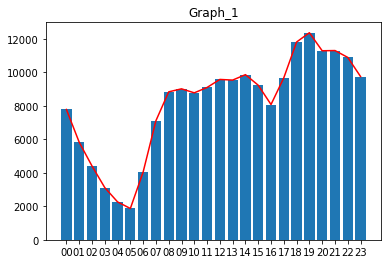

In [19]:
# Q1

data = [i[0] for i in query1]
x_var = [i[1] for i in query1]

plt.title('Graph_1')
plt.bar(x_var, data)
plt.plot(x_var, data, color='red')
plt.show()

In [20]:
# Q2
def Q2(i: int) -> str:
    Q2 = f"""
SELECT a."Trip_distance"
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE time == '{i}'
"""
    return Q2

In [25]:
def Q2_num(i: int) -> str:
    Q2 = f"""
SELECT count(a."Trip_distance")
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE time == '{i}'
"""
    return Q2

In [7]:
def get_elements() -> list:
    tag = ['01','02','03','04','05','06','07','08','09','10','11','12']
    mean = []
    lb = []
    ub = []
    for i in tag:
        q2 = engine.execute(Q2(i)).fetchall()
        q2_num = engine.execute(Q2_num(i)).fetchall()
        avg = np.mean(q2)
        std = np.std(q2)
        lower = avg - 1.645 * std / np.sqrt(int(q2_num[0][0]))
        upper = avg + 1.645 * std / np.sqrt(int(q2_num[0][0]))
        mean.append(avg)
        lb.append(lower)
        ub.append(upper)
    return tag, mean, lb, ub

def plot_visual_2(tag: list, mean: list, lb: list, ub: list) -> None:   
    plt.figure(dpi=100,figsize=(6,6))
    plt.title('Graph 2')
    tag = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.plot(tag, mean, color='red', label='AVG')
    plt.fill_between(tag, lb, ub, label='CI')
    plt.xlabel('Month')
    plt.ylabel('km')
    plt.legend()
    plt.show()

[sqlalchemy] 
SELECT a."Trip_distance"
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE time == '01'

[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT count(a."Trip_distance")
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE time == '01'

[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT a."Trip_distance"
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE time == '02'

[sqlalchemy] [raw sql] ()
[sqlalchemy] 
SELECT count(a."Trip_distance")
FROM
(SELECT strftime ('%m', date) as time, "Trip_distance"
FROM uber_data
UNION ALL
SELECT strftime ('%m', pickup_datetime) as time, trip_distance
FROM taxi_data 
) as a
WHERE ti

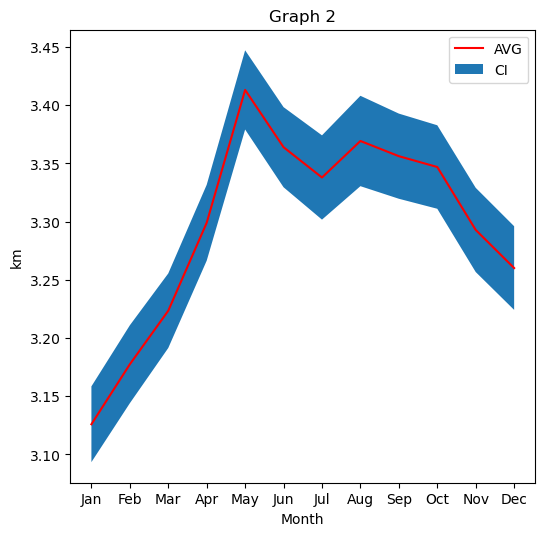

In [27]:
tag, mean, lb, ub = get_elements()
plot_visual_2(tag, mean, lb, ub)

In [6]:
## Q3
# LGA -73.898077,40.763966,-73.852587,40.786520
# JFK -73.828125,40.619946,-73.738518,40.670483
# EWK -74.203033,40.666056,-74.143982,40.715517

def cal_coor(min_longitutde: float, min_latitude: float, max_longitutde: float, max_latitude: float) -> list:
    uber = uber_data.loc[(uber_data['pickup_longitude'] <=  max_longitutde) & (uber_data['pickup_longitude'] >=  min_longitutde)\
                    & (uber_data['dropoff_longitude'] <=  max_longitutde) & (uber_data['dropoff_longitude'] >=  min_longitutde)
                    & (uber_data['pickup_latitude'] <=  max_latitude) & (uber_data['pickup_latitude'] >=  min_latitude) \
                    & (uber_data['dropoff_latitude'] <=  max_latitude) & (uber_data['dropoff_latitude'] >=  min_latitude)]
    uber_num = uber.groupby(by='week_name').count().passenger_count

    taxi = taxi_data.loc[(taxi_data['pickup_longitude'] <=  max_longitutde) & (taxi_data['pickup_longitude'] >=  min_longitutde)\
                    & (taxi_data['dropoff_longitude'] <=  max_longitutde) & (taxi_data['dropoff_longitude'] >=  min_longitutde)
                    & (taxi_data['pickup_latitude'] <=  max_latitude) & (taxi_data['pickup_latitude'] >=  min_latitude) \
                    & (taxi_data['dropoff_latitude'] <=  max_latitude) & (taxi_data['dropoff_latitude'] >=  min_latitude)]
    taxi['week_name'] = taxi['pickup_datetime'].dt.day_name()
    taxi_num = taxi.groupby(by='week_name').count().passenger_count
    
    return uber_num + taxi_num


def plot_visual_3(LGA: list, JFK: list, EWK: list) -> None: 
    plt.figure(dpi=100,figsize=(6,6))
    plt.title('Graph 3')
    plt.plot(LGA.index, LGA.values, label='LGA')
    plt.plot(list(LGA).index(max(LGA.values)),LGA[list(LGA).index(max(LGA.values))],'ko') 
    plt.plot(JFK.index, JFK.values, label='JFK')
    plt.plot(list(JFK).index(max(JFK.values)),JFK[list(JFK).index(max(JFK.values))],'ko') 
    plt.plot(EWK.index, EWK.values, label='EWK')
    plt.plot(list(EWK).index(max(EWK.values)),EWK[list(EWK).index(max(EWK.values))],'ko') 



    plt.annotate(LGA.index[list(LGA).index(max(LGA.values))],xy=(list(LGA).index(max(LGA.values)),LGA[list(LGA).index(max(LGA.values))]))
    plt.annotate(JFK.index[list(JFK).index(max(JFK.values))],xy=(list(JFK).index(max(JFK.values)),JFK[list(JFK).index(max(JFK.values))]))
    plt.annotate(EWK.index[list(EWK).index(max(EWK.values))],xy=(list(EWK).index(max(EWK.values)),EWK[list(EWK).index(max(EWK.values))]))



    plt.xlabel('Day')
    plt.ylabel('Number')
    plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
    plt.show()

In [5]:
LGA = cal_coor(-73.898077,40.763966,-73.852587,40.786520)
JFK = cal_coor(-73.828125,40.619946,-73.738518,40.670483)
EWK = cal_coor(-74.203033,40.666056,-74.143982,40.715517).fillna(0)
plot_visual_3(LGA, JFK, EWK)

NameError: name 'uber_data' is not defined

In [3]:
## Q4 create heatmap
def plot_visual_4(uber: float, taxi: float) -> None: 
    heatmap = folium.Map(
        location=[40.7344845, -73.9796885],
        zoom_start=8)
    # uber and taxi data
    rides_1 = uber[['pickup_latitude', 'pickup_longitude']]
    rides_2 = uber[['dropoff_latitude', 'dropoff_longitude']]
    rides_3 = taxi[['pickup_latitude', 'pickup_longitude']]
    rides_4 = taxi[['dropoff_latitude', 'dropoff_longitude']]
    heatmap.add_children(plugins.HeatMap(rides_1, radius=15))
    heatmap.add_children(plugins.HeatMap(rides_2, radius=15))
    heatmap.add_children(plugins.HeatMap(rides_3, radius=15))
    heatmap.add_children(plugins.HeatMap(rides_4, radius=15))
    # The most popular area coords
    folium.Marker(
            location=[40.754107, -73.9824]
            ).add_to(heatmap)
    return heatmap

In [1]:
plot_visual_4(uber_data, taxi_data) 

NameError: name 'plot_visual_4' is not defined

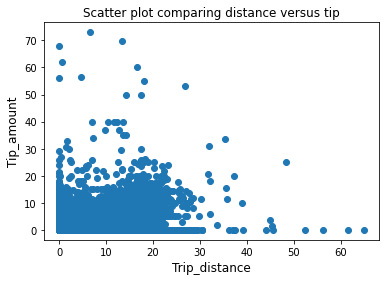

In [24]:
#Q5  Create a scatter plot that comopares tip amount versus distance
trip_distance = taxi_data['trip_distance']
tip_amount =taxi_data['tip_amount']
plt.scatter(trip_distance,tip_amount)
plt.xlabel('Trip_distance',fontsize = 12)
plt.ylabel('Tip_amount',fontsize = 12)
plt.title('Scatter plot comparing distance versus tip')
plt.show()

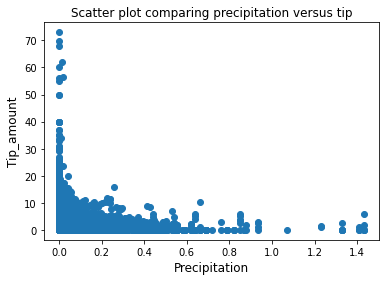

In [103]:
#Q6 Create a scatter plot that compares tip amount versus precipitation
a = taxi_data[['pickup_datetime','tip_amount']]
a['DATE'] = a['pickup_datetime'].dt.strftime('%Y-%m-%d-%H')
b = weather_hourly[['DATE','HourlyPrecipitation']]
b['DATE'] = b['DATE'].dt.strftime('%Y-%m-%d-%H')
c = b.loc[b['DATE']<= '2015-06-30-23']
d = c.groupby(by='DATE').mean()
e = pd.merge(a,d,how = 'left', on = 'DATE')
Precipitation = e['HourlyPrecipitation']
tip_amount =e['tip_amount']
plt.scatter(Precipitation,tip_amount)
plt.xlabel('Precipitation',fontsize = 12)
plt.ylabel('Tip_amount',fontsize = 12)
plt.title('Scatter plot comparing precipitation versus tip')
plt.show()

In [ ]:
#Q7-1
#First question: how the snow affect the number of rides during a time period (2009-01-01 - 2019-01-10)
#compared with normal weather
# In this question, we sample the hours under normal weather to make it equal to hours under snow.

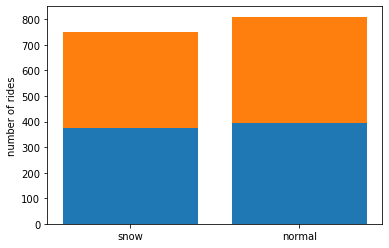

In [320]:
snow = weather_hourly[(weather_hourly['HourlyPresentWeatherType'] == '|SN |') & (weather_hourly['DATE'] < '2009-01-31-23')]
normal = weather_hourly[(weather_hourly['DATE'] < '2009-01-31-23') & (weather_hourly['HourlyPresentWeatherType'] == '0')]
normal = normal.sample(len(snow)).sort_values(by = 'DATE')
normal['DATE'] = normal['DATE'].dt.strftime('%Y-%m-%d-%H')
snow['DATE'] = snow['DATE'].dt.strftime('%Y-%m-%d-%H')
normal = normal[['DATE','HourlyPresentWeatherType']]
snow = snow[['DATE','HourlyPresentWeatherType']]
uber = uber_data[['raw_date','date']]
uber['raw_date'] = pd.to_datetime(uber['raw_date'])
uber['DATE'] = uber['raw_date'].dt.strftime('%Y-%m-%d-%H')

uber_norm = sum(uber.merge(normal, how = 'inner', on = 'DATE').groupby('DATE').count()['HourlyPresentWeatherType'])

uber_snow = sum(uber.merge(snow, how = 'inner', on = 'DATE').groupby('DATE').count()['HourlyPresentWeatherType'])

taxi = taxi_data[['pickup_datetime','dropoff_datetime']]
taxi['DATE'] = taxi['pickup_datetime'].dt.strftime('%Y-%m-%d-%H')

taxi_snow = sum(taxi.merge(normal, how = 'inner', on = 'DATE').groupby('DATE').count()['HourlyPresentWeatherType'])

taxi_norm = sum(taxi.merge(snow, how = 'inner', on = 'DATE').groupby('DATE').count()['HourlyPresentWeatherType'])

x = ['snow','normal']
y = [uber_snow,uber_norm]
z = [taxi_snow,taxi_norm]
plt.bar(x,y)
plt.bar(x,z,bottom = y)
plt.ylabel('number of rides')
plt.show()

In [2]:
#Q7-2
# Second question: we want to know relationship between temperature and amount of the trips

def plot_visual() -> None:
    QUERY_7 = """
    SELECT b.b_time, avg(b.fare), weather_daily."DailyDryBulbTemperature"

    FROM
    (SELECT a.time as b_time, avg(a.fare_amount) as fare
    FROM
    (SELECT strftime ('%Y-%m', date) as time, fare_amount
    FROM uber_data
    UNION ALL
    SELECT strftime ('%Y-%m', pickup_datetime) as time, fare_amount
    FROM taxi_data ) as a
    GROUP BY time) as b 

    JOIN weather_daily
    ON b.b_time = strftime ('%Y-%m', weather_daily."DATE")
    GROUP BY b.b_time
    ORDER BY b.b_time ASC
    """
    query7 = engine.execute(QUERY_7).fetchall()
    tag = [i[0] for i in query7] 
    fare = np.array([i[1] for i in query7])
    temp = np.array([i[2] for i in query7]) 

    plt.figure(dpi=100,figsize=(6,6))
    plt.title('Graph 7-2')
    plt.scatter(temp, fare)
    plt.xlabel('Temperature')
    plt.ylabel('Fare_amount')
    plt.show()

[sqlalchemy] 
    SELECT b.b_time, avg(b.fare), weather_daily."DailyDryBulbTemperature"

    FROM
    (SELECT a.time as b_time, avg(a.fare_amount) as fare
    FROM
    (SELECT strftime ('%Y-%m', date) as time, fare_amount
    FROM uber_data
    UNION ALL
    SELECT strftime ('%Y-%m', pickup_datetime) as time, fare_amount
    FROM taxi_data ) as a
    GROUP BY time) as b 

    JOIN weather_daily
    ON b.b_time = strftime ('%Y-%m', weather_daily."DATE")
    GROUP BY b.b_time
    ORDER BY b.b_time ASC
    
[sqlalchemy] [raw sql] ()


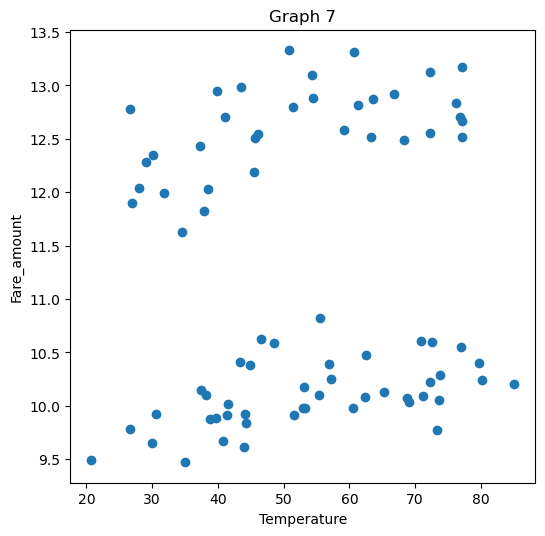

In [37]:
plot_visual()

In [ ]:
#Q7-3
#Third question: we want to know the relationship between amount of tips and number of passengers

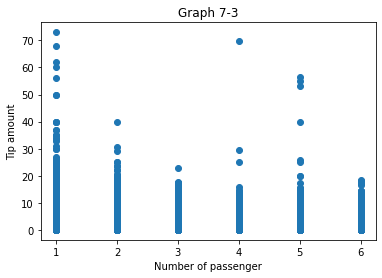

In [75]:
taxi = taxi_data[['passenger_count','tip_amount']].loc[taxi_data['passenger_count'] != 0]
num_pass = taxi['passenger_count']
tip = taxi['tip_amount']
plt.scatter(num_pass,tip)
plt.title('Graph 7-3')
plt.xlabel('Number of passenger')
plt.ylabel('Tip amount')
plt.show()